https://www.nltk.org/book/ch05.html

Need to reduce more common words...

Need to prevent overfitting. Keeps predicting the same word for every possible input.

Replace mean squared with mean cube/fourth? Something to prioritize the largest errors.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
from nltk.corpus import brown
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
len(pd.Series(brown_news_tagged).unique())

15114

In [268]:
len(brown.words())

KeyboardInterrupt: 

In [41]:
def tensor_to_array(t):
    return np.array([i.item() for i in list(t)])

# Prepare Corpus

In [195]:
remove_punc = [word for word in brown_news_tagged if word[1] != "."]
text = [word[0].lower() for word in remove_punc][:5000]
# text = word_tokenize(open("text.txt", "r").readline())
len(text)

5000

In [196]:
pd.Series(text).value_counts()["called"]

2

In [197]:
corpus = pd.Series([word for word in text]).unique()
len(corpus)

1646

In [198]:
vecs = {}
dim = 128
for i in range(len(corpus)):
    vecs[corpus[i]] = np.random.random(dim)*2 - np.ones(dim)

# Train Model

In [199]:
scanning_window = 5

num_train_datapoints = int(0.8 * (len(text)-2*scanning_window))

## Define Net

In [200]:
class Net(nn.Module):

    def __init__(self, in_len):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2*scanning_window*in_len, 512) #to embedding layer (the internal representation of the input word)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, in_len) #to output (word before, word after)
    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
    def embeddings(self, x):
        x = self.fc1(x)
        return x
    def loss_score(self, x, y):
        l = 0
        for i in range(len(x)):
            output = self(x[i])
            target = y[i]
            criterion_temp = nn.MSELoss()
            loss = criterion_temp(output, target)
            l += loss.item()/len(x)
        return l


## Use Net

In [238]:
net = Net(dim)

params = list(net.parameters())

net.zero_grad()

# def criterion(input, target):
#     return sum((a-b)**3 for a,b in zip(input, target))/len(input)
criterion = nn.MSELoss()
# nn.CosineEmbeddingLoss()
# nn.MSELoss()
# nn.BCELoss
# nn.LocalResponseNorm

In [239]:
# create your optimizer
losses = []
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [240]:
def generate_training_data(index, window = 10, data=text):
    focus_word = data[index+window]
    input_list = vecs[focus_word]

    o = []
    i = 0
    for i in range(-window, 0):
        if index + i + window >= 0:
            o += list(vecs[data[index + i + window]])
    #skip index 0 - focus word
    for i in range(1, window+1):
        if index + i + window < len(data):
            o += list(vecs[data[index + i + window]])

    return torch.tensor([float(a) for a in input_list]), torch.tensor([float(a) for a in o]), focus_word

In [252]:
NUM_RUNS = 5
for run_num in range(NUM_RUNS):
    print("RUN", str(run_num+1)+"/"+str(NUM_RUNS), end=": ")
    for i in range(0,num_train_datapoints,1):
        if i % (num_train_datapoints//20) == 0:
            print("•", end="")
        
        target, input, focus_word = generate_training_data(i, window = scanning_window)
        
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(input)

        adjust_vecs_constant = 0.5
        new_target = adjust_vecs_constant * output + (1-adjust_vecs_constant) * target

        vecs[focus_word] = tensor_to_array(new_target)

        loss = criterion(output, target)
        
        loss.backward()

        optimizer.step()    # Does the update

        losses.append(loss.item())
        # losses.append(criterion(output, new_target))
    # plt.plot(losses)
    # plt.show()
    print()

RUN 1/5: •••••••••••••••••••••
RUN 2/5: •••••••••••••••••••••
RUN 3/5: •••••••••••••••••••••
RUN 4/5: •••••••••••••••••••••
RUN 5/5: •••••••••••••••••••••


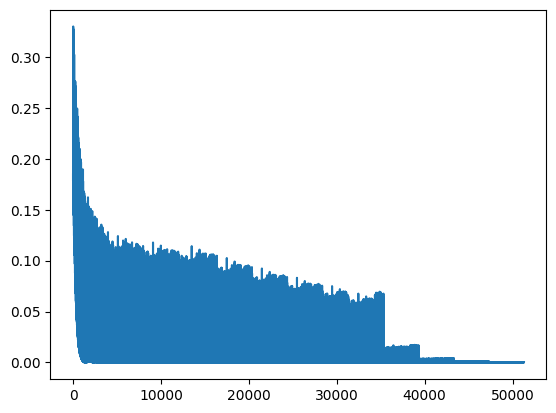

In [253]:
plt.plot(losses)
plt.show()

# Test Model

In [260]:
def words_around(word):
    return net(word)



In [261]:
corpus

array(['the', 'fulton', 'county', ..., 'those', 'rise', '7.5'],
      dtype=object)

In [256]:
text_11_words = "the people have conducted an investigation into this information which was illegal"
gen = text_11_words.split(" ")
for i in range(1):
    input, output, word = generate_training_data(i, window=scanning_window, data=gen)
    o = net(output)
    max_i = -1
    for j in range(len(o)):
        if o[j].item() > o[max_i].item():
            max_i = j
    gen.insert(i + scanning_window, corpus[max_i])
print(" ".join(gen))


the people have conducted an laws investigation into this information which was illegal


In [257]:
input = -1000*torch.ones(2*dim*scanning_window)
o = net(input)
o
max_i = -1
for i in range(len(o)):
    if o[i].item() > o[max_i].item():
        max_i = i
max_i
corpus[max_i]

'which'

In [266]:
def cos_similarity(a, b):
    s = 0
    for i in range(len(a)):
        s += a[i] * b[i]
    s /= sum(e**2 for e in a)**0.5
    s /= sum(e**2 for e in b)**0.5
    return s
ref = vecs["the"]

In [267]:
min_word = corpus[0]
for word in corpus:
    s = cos_similarity(vecs[word], ref)
    if s != 0 and s <= cos_similarity(vecs[min_word], ref):
        min_word = word
print(min_word)
print()

social

